In [ ]:
# Install required packages
!pip install transformers datasets torch scikit-learn nltk -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
import torch
import nltk
nltk.download('punkt')
# Download the missing 'punkt_tab' resource
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset from Google Drive (Update path)
df = pd.read_csv("/content/drive/MyDrive/Suicide_Detection.csv")

In [ ]:
# Balance & label encode
suicide = df[df['class'] == 'suicide'].head(30000)
non_suicide = df[df['class'] == 'non-suicide'].head(30000)
df_balanced = pd.concat([suicide, non_suicide]).reset_index(drop=True)
df_balanced['label'] = df_balanced['class'].map({'suicide': 1, 'non-suicide': 0})

In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    return " ".join(tokens)

df_balanced['text'] = df_balanced['text'].astype(str).apply(preprocess_text)

In [ ]:
# Split into train/val/test
train_val, test = train_test_split(df_balanced, test_size=0.15, stratify=df_balanced['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.1765, stratify=train_val['label'], random_state=42)  # 0.1765 ≈ 15/(85)

In [ ]:
# Convert to Hugging Face Dataset
dataset_dict = DatasetDict({
    'train': Dataset.from_pandas(train[['text', 'label']].reset_index(drop=True)),
    'validation': Dataset.from_pandas(val[['text', 'label']].reset_index(drop=True)),
    'test': Dataset.from_pandas(test[['text', 'label']].reset_index(drop=True)),
})

In [ ]:
# Tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Tokenize
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/41998 [00:00<?, ? examples/s]

Map:   0%|          | 0/9002 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
!pip install --upgrade transformers -q  # Make sure transformers is upgraded
from transformers import TrainingArguments

# Training arguments (50 epochs)
training_args = TrainingArguments(
    output_dir="./results",
    # Replace 'evaluation_strategy' with 'eval_strategy'
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    logging_dir="./logs",
    fp16=torch.cuda.is_available()
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [ ]:
# Train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: u1909015 (u1909015-chittagong-university-scientific-society) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.120000,0.099861,0.975117,0.975205,0.971763,0.978671
2,0.083800,0.105468,0.977338,0.977568,0.967777,0.987558
3,0.043100,0.108672,0.978560,0.978742,0.970511,0.987114
4,0.023100,0.132693,0.978005,0.977743,0.989534,0.966230
5,0.006500,0.131333,0.980671,0.980598,0.984330,0.976894


TrainOutput(global_step=26250, training_loss=0.06435406601315453, metrics={'train_runtime': 3074.8115, 'train_samples_per_second': 68.294, 'train_steps_per_second': 8.537, 'total_flos': 1.38126726287616e+16, 'train_loss': 0.06435406601315453, 'epoch': 5.0})

In [ ]:
# Evaluate on test set
results = trainer.evaluate(tokenized_datasets["test"])
print("Final Test Results:", results)

Final Test Results: {'eval_loss': 0.14095538854599, 'eval_accuracy': 0.98, 'eval_f1': 0.9799420548250501, 'eval_precision': 0.9827894501564596, 'eval_recall': 0.9771111111111112, 'eval_runtime': 17.1489, 'eval_samples_per_second': 524.814, 'eval_steps_per_second': 32.83, 'epoch': 5.0}


In [ ]:
example_texts = [
    "I feel like everything is falling apart. I can't do this anymore.",
    "I had a wonderful day with friends and I feel happy."
]

In [ ]:
inputs = tokenizer(example_texts, padding=True, truncation=True, return_tensors="pt").to(model.device)
with torch.no_grad():
    outputs = model(**inputs)
preds = torch.argmax(outputs.logits, dim=1)
print("Predictions:", preds.tolist())  # 1 = suicide, 0 = non-suicide

Predictions: [1, 0]


In [ ]:
logging_dir="./logs",
logging_strategy="epoch",  # log every epoch

In [ ]:
# Get training logs (all epochs)
history = trainer.state.log_history


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
df_history = pd.DataFrame(history)

# Filter for loss and F1 entries
train_loss = df_history[df_history['loss'].notna()]
eval_loss = df_history[df_history['eval_loss'].notna()]
eval_f1 = df_history[df_history['eval_f1'].notna()]


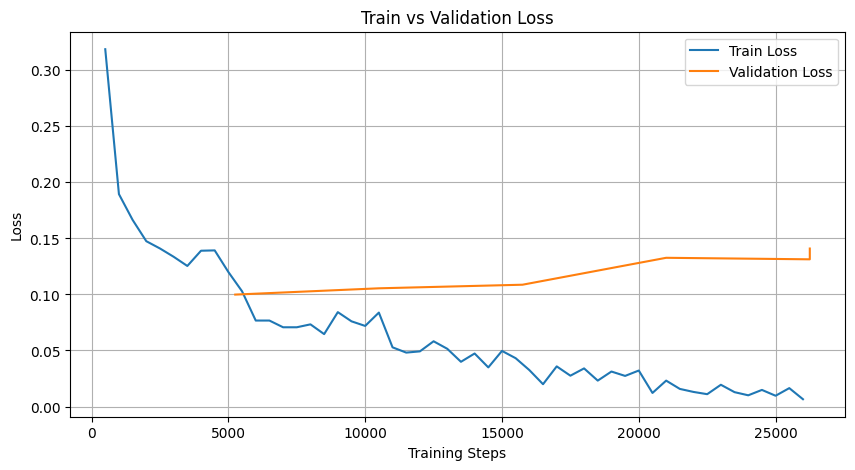

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss['step'], train_loss['loss'], label='Train Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Validation Loss')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


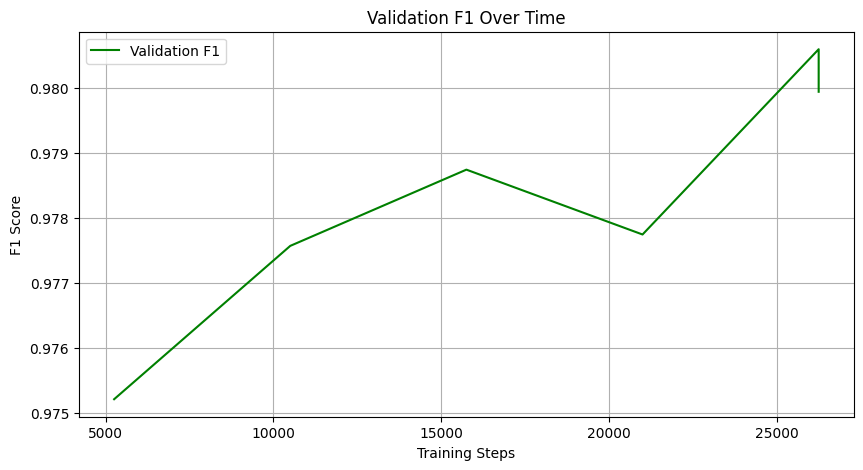

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(eval_f1['step'], eval_f1['eval_f1'], label='Validation F1', color='green')
plt.xlabel("Training Steps")
plt.ylabel("F1 Score")
plt.title("Validation F1 Over Time")
plt.legend()
plt.grid(True)
plt.show()


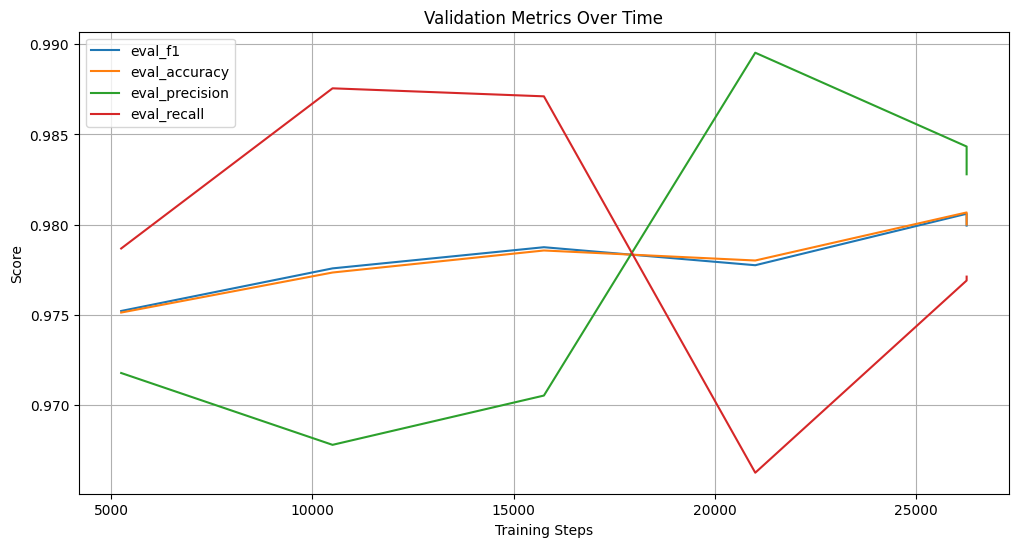

In [ ]:
metrics = ['eval_f1', 'eval_accuracy', 'eval_precision', 'eval_recall']

plt.figure(figsize=(12, 6))
for metric in metrics:
    if metric in df_history.columns:
        metric_data = df_history[df_history[metric].notna()]
        plt.plot(metric_data['step'], metric_data[metric], label=metric)
plt.xlabel("Training Steps")
plt.ylabel("Score")
plt.title("Validation Metrics Over Time")
plt.legend()
plt.grid(True)
plt.show()


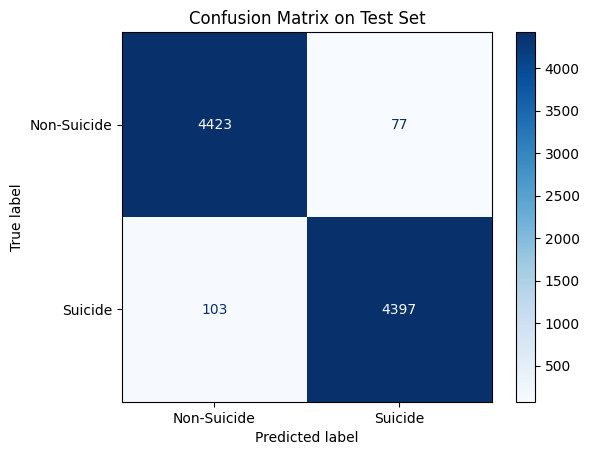

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
predictions = trainer.predict(tokenized_datasets['test'])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Suicide', 'Suicide'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()


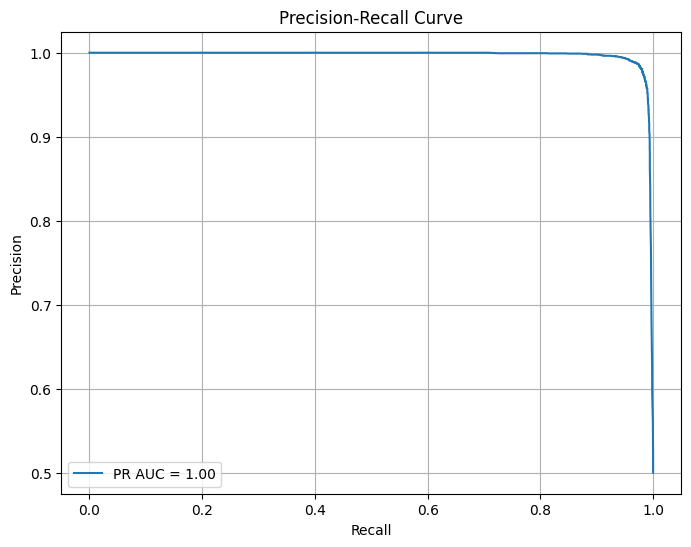

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

probs = predictions.predictions[:, 1]  # Probability for class 1
precision, recall, thresholds = precision_recall_curve(y_true, probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()
